# Nueral Style Transfer Project

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from torchvision.utils import save_image
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Image size
image_size = 356

# Loader
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [61]:
def load_image(image_name):
    image = Image.open(image_name)
    plt.imshow(image)
    image = loader(image).unsqueeze(0)
    return image.to(device)

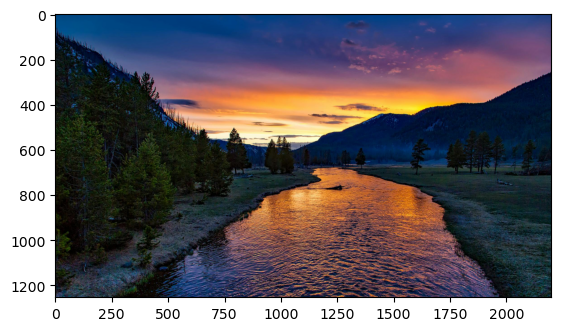

In [63]:
# Load images
original_img = load_image("ContentImages/river.png")

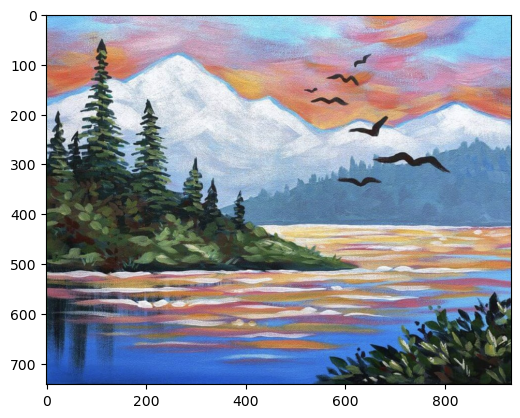

In [64]:
style_img = load_image("StyleImages/Mountain.jpg")

In [66]:
# VGG Feature Extractor
class VGG(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super().__init__()

        vgg = vgg19(weights=VGG19_Weights.DEFAULT).features
        self.selected_indices = {0, 5, 10, 19, 28}
        self.layers = nn.ModuleList(list(vgg.children()))

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i in self.selected_indices:
                features.append(x)
        return features

In [69]:
#Noice Image
generated_image = nn.Parameter(original_img.clone())

# Load model
model = VGG().to(device).eval()

for p in model.parameters():
    p.requires_grad_(False)

# Hyperparameters
total_steps   = 1500
learning_rate = 0.003
alpha = 1.0
beta = 0.3
losses = []

optimizer = optim.Adam([generated_image], lr=learning_rate, betas=[0.5, 0.999])
# optimizer = torch.optim.LBFGS([generated_image], lr=1.0, max_iter=20)

In [70]:
# Training Loop
for step in range(total_steps):

    generated_features = model(generated_image)
    original_features = model(original_img)
    style_features = model(style_img)

    style_loss = 0
    original_loss = 0

    for gen_f, orig_f, sty_f in zip(generated_features, original_features, style_features):

        batch_size, channel, height, width = gen_f.shape

        # Content Loss
        original_loss += torch.mean((gen_f - orig_f) ** 2)

        # Gram Matrices
        G = gen_f.view(channel, height * width).mm(
            gen_f.view(channel, height * width).t()
        )
        A = sty_f.view(channel, height * width).mm(
            sty_f.view(channel, height * width).t()
        )

        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    losses.append(total_loss.item())

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Loss = {total_loss.item():.4f}")
        # save_image(generated_image, f"Generated2/generated_{step}.png")
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        img = generated_image.clone().squeeze()
        img = denorm(img).clamp_(0, 1)
        torchvision.utils.save_image(img, f"GeneratedImages/Mountain_River_OG/generated_{step}.png")


    
        

Step 0, Loss = 133726400.0000
Step 100, Loss = 51464584.0000
Step 200, Loss = 33629964.0000
Step 300, Loss = 23955546.0000
Step 400, Loss = 17954590.0000
Step 500, Loss = 13958393.0000
Step 600, Loss = 11190732.0000
Step 700, Loss = 9217475.0000
Step 800, Loss = 7761366.5000
Step 900, Loss = 6647008.5000
Step 1000, Loss = 5768504.0000
Step 1100, Loss = 5055080.0000
Step 1200, Loss = 4462848.5000
Step 1300, Loss = 3961956.7500
Step 1400, Loss = 3532213.2500


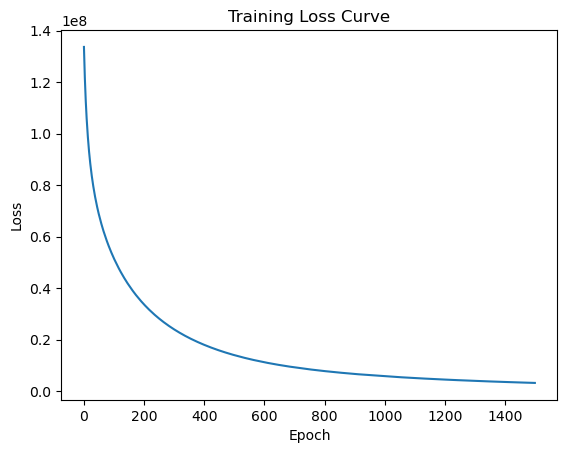

In [72]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

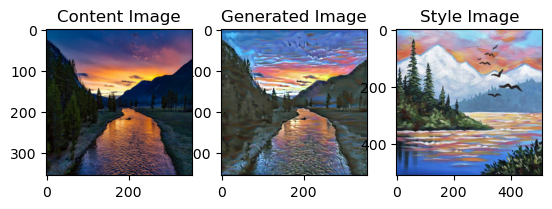

In [134]:
plt.subplot(1, 3, 2)
image = Image.open("GeneratedImages/Mountain_River_OG/generated_1400.png")
plt.title("Generated Image")
plt.imshow(image)

plt.subplot(1, 3, 1)
image = Image.open("ContentImages/Resized/river.png")
plt.title("Content Image")
plt.imshow(image)

plt.subplot(1, 3, 3)
image = Image.open("StyleImages/Mountain_resized.jpg")
plt.title("Style Image")
plt.imshow(image)

plt.show()